In [1]:
from tensorflow.keras.layers import Dense, Input, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import resnet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
batch_size = 64
width, height, channel = 400, 400, 3
no_epochs = 10
verbosity = 2
input_shape = (width, height, channel)

In [3]:
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=input_shape,
    pooling=None,
    classes=1000
)

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory('preprocessed_data/train',
                                                    target_size=(400, 400),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')


pretrained_model.trainable=False

model=Sequential()

# model.add(pretrained_model)

model = tf.keras.Sequential()

for layer in pretrained_model.layers[:-1]: # just exclude last layer from copying
    model.add(layer)
    
for layer in model.layers:
    layer.trainable = False

# model.add(MaxPooling2D())
# model.add(Dropout(0.2))
# model.add(Flatten())
# model.add(Dense(2, activation='softmax'))

model.add(tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[metrics.AUC(), 'accuracy'])

Found 2603 images belonging to 2 classes.


In [5]:
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples//batch_size,
                    epochs = no_epochs,
                    verbose=verbosity,
                   )

Epoch 1/10
40/40 - 23s - loss: 0.7946 - auc: 0.6299 - accuracy: 0.6081
Epoch 2/10
40/40 - 22s - loss: 0.5335 - auc: 0.8248 - accuracy: 0.7487
Epoch 3/10
40/40 - 22s - loss: 0.4698 - auc: 0.8622 - accuracy: 0.7755
Epoch 4/10
40/40 - 23s - loss: 0.4168 - auc: 0.8975 - accuracy: 0.8200
Epoch 5/10
40/40 - 23s - loss: 0.4128 - auc: 0.8918 - accuracy: 0.8019
Epoch 6/10
40/40 - 22s - loss: 0.3582 - auc: 0.9237 - accuracy: 0.8444
Epoch 7/10
40/40 - 22s - loss: 0.3315 - auc: 0.9356 - accuracy: 0.8551
Epoch 8/10
40/40 - 23s - loss: 0.3245 - auc: 0.9364 - accuracy: 0.8594
Epoch 9/10
40/40 - 22s - loss: 0.2999 - auc: 0.9472 - accuracy: 0.8688
Epoch 10/10
40/40 - 23s - loss: 0.2968 - auc: 0.9473 - accuracy: 0.8712


In [6]:
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_directory('preprocessed_data/test',
                                                    target_size=(400, 400),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

model.evaluate(valid_generator)

Found 650 images belonging to 2 classes.
11/11 [==============================] - 6s 507ms/step - loss: 0.2502 - auc: 0.9702 - accuracy: 0.9015


[0.2501952350139618, 0.9702378511428833, 0.9015384912490845]

In [7]:
# https://dryjelly.tistory.com/147

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt

In [9]:
get_output = tf.keras.backend.function([model.layers[0].input],
                                       [model.layers[-3].output, model.layers[-1].output])
[conv_outputs, predictions] = get_output(valid_generator[0][0])
class_weights = model.layers[-1].get_weights()[0]

In [10]:
output = []
for num, idx in enumerate(np.argmax(predictions,axis=1)):
    cam = tf.matmul(np.expand_dims(class_weights[:,idx],axis = 0),
                    np.transpose(np.reshape(conv_outputs[num],(25*25,1024))))
    cam = tf.keras.backend.eval(cam)
    output.append(cam)

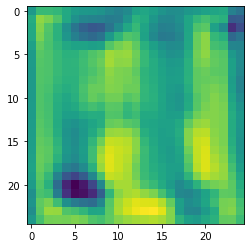

In [23]:
plt.imshow(np.reshape(output[0][0], (25, 25)))

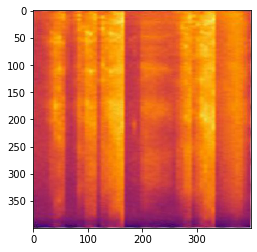

In [31]:
plt.imshow(valid_generator[0][0][0])